# Physical model for joint analyses from multiple instruments


This notebook shows how to make **Naima** as an user defined model of Gammapy to do the physical modeling 
of the observed data. Datails on **Naima** can be found in this link: http://naima.readthedocs.io/en/latest/ 

        
In this example data from three different telescopes, HESS, MAGIC, VERITAS, FACT, & FERMI-LAT is used.  In the paper the 
multi instrument data is fit with LogParabola model. Here, physical models (i.e. synchrotron, inverse 
Compton proecesses) are considered as the model to fit the data through log likelihood method. Hence, 
this fitting procedure is different from the usual SED fitting.

Since, the physical processes need electron spectrum, hence the parameters of the electron distribution
are essentially inputs to this procedure. 

In this example, we consider electron spectrum as a LogParabola model. One can also consider power-law 
distribution of electrons which is also provided with the package. Other spectral shapes 
can be easily developed using the prescription given in these two spectral models.



****

# Setup

Some usual checks for setup 

In [1]:
# to check if the python version 3.6 is getting imported
# This part should be deleted in the final version
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import gammapy
import naima
import numpy as np
import astropy.units as u
from pathlib import Path
from astropy.table import Table

from astropy.io import ascii
from gammapy.spectrum import models
from gammapy.utils.modeling import Parameter

from gammapy.spectrum import (
    models, SpectrumExtraction, SpectrumFit, SpectrumResult,
    SpectrumEnergyGroupMaker, FluxPointEstimator,SpectrumObservationList,SpectrumObservation
)

sys.path.append('..')
from joint_crab.conf import config
from naima.models import InverseCompton, ExponentialCutoffPowerLaw

# This part should also be deleted in the final version
print('gammapy:', gammapy.__version__)

/photon1/users/labsaha/miniconda/envs/gammapy-dev/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


gammapy: 0.8.dev7078


## Naima as user defined model of Gammapy. 

Here Naima is used as model for SpectrumFit class of Gammapy. Here the `CrabSpectrumModel` is built
following the prescription given in Gammapy package 
(http://docs.gammapy.org/dev/notebooks/spectrum_models.html?highlight=usermodel#User-defined-model)

In [2]:
import naima
import astropy.units as u
from gammapy.utils.modeling import Parameter,Parameters
import gammapy.spectrum.models
import naima.models


class CrabSpectrumModel(gammapy.spectrum.models.SpectralModel):
    def __init__(self, alpha, amplitude,beta,reference):
        self.parameters = Parameters([
            Parameter('alpha', alpha),
            Parameter('amplitude', amplitude),
            Parameter('beta', beta),
            Parameter('reference', reference, frozen=True)
        ])

    @staticmethod
    def evaluate(energy, alpha, amplitude, beta, reference):
        # Initialize instances of the particle distribution and radiative model
        particle_distribution = naima.models.LogParabola(amplitude, reference, alpha, beta)
        # Compute IC on CMB (for other components see the link https://naima.readthedocs.io/en/latest/)
        # ------------------------------------------------------------------
        ic_model = naima.models.InverseCompton(
            particle_distribution,
            seed_photon_fields=['CMB'],
            Eemin=100 * u.GeV,
        )
       
        # compute flux at the energies given in data['energy']
        dnde = ic_model.flux(energy, distance=1.0 * u.kpc)

        return dnde.to('cm-2 s-1 TeV-1')


# Model definition

In this example we consider input electron spectrum as a LogParabola type spectrum 
as model for **Naima**. In the present **Naima** model only CMB photons are considered for IC process.
It generally takes time to get the best-fit parameters of the model if we include other components 
for IC process. 

In [3]:
# parameters of the LogParabola electron spectrum

model_naima = CrabSpectrumModel(
        alpha=2.0,
        amplitude=1.0e+37 * u.Unit('eV-1'),
        beta = 0.5 * u.Unit(''),
        reference = 0.1 *u.Unit('TeV'),
      )

# In case one want to freeze on of the model parameters
# model_naima.parameters['beta'].frozen = True
# model_naima.parameters['alpha'].frozen = True

# In case we want to see the SED before fitting
#energy_range = [.003, 500] * u.TeV
#fig, ax = plt.subplots(1)
#model_naima.plot(ax=ax,energy_range=energy_range,energy_power=2)
#plt.loglog()

# Fit

Naima model is being used as the model for likelihood fit of the FERMI-LAT, MAGIC, HESS, VERITAS, 
and FACT data.




In [4]:
import warnings 
warnings.simplefilter("ignore")

#getting observation list available for joint-crab analysis
#One can consider all data to do the joint fit or data from individual instruments

# For all instruments together
#dataset = config.get_dataset('joint')

# For individual instruments (any one these: 'fermi','hess','magic','veritas', 'fact')
dataset = config.get_dataset('fermi')

obs_list = dataset.get_SpectrumObservationList()
print(obs_list)

SpectrumObservationList
Number of observations: 1


In [5]:
# Energy range used for the fit
energy_range = dataset.energy_range

# Copy original model to model_fit (after fitting the model_fit will be overwrtiiten to the fitted model)
model = model_naima.copy()

# fit the data
fit = SpectrumFit(obs_list=obs_list, model = model, fit_range=energy_range, method='iminuit')
#fit.fit()
fit.fit(opts_minuit={'print_level': 2})
fit.est_errors()

# Print the best-fit parameters
print(fit.result[0])
# copy the best-fit model to a new object 'model_fit'
model_fit = model.copy()

FCN = 10.891409158954515 
 TOTAL NCALL = 780 
 NCALLS = 780 
 
 
 EDM = 0.00010274107871584542 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_alpha,1.24245,0.822104,0,0,,,
2,par_001_amplitude,3.05865,4.74335,0,0,,,
3,par_002_beta,0.246182,0.108249,0,0,,,
4,par_003_reference,1,1,0,0,,,FIXED



Fit result info 
--------------- 
Model: CrabSpectrumModel

Parameters: 

	   name     value     error    unit  min max
	--------- --------- --------- ------ --- ---
	    alpha 1.242e+00 8.221e-01        nan nan
	amplitude 3.059e+37 4.743e+37 1 / eV nan nan
	     beta 2.462e-01 1.082e-01        nan nan
	reference 1.000e-01 0.000e+00    TeV nan nan

Covariance: 

	   name           alpha          ...          beta         reference
	--------- ---------------------- ... --------------------- ---------
	    alpha     0.6758548543744473 ...  -0.08816883283406794       0.0
	amplitude 3.8674565000220565e+37 ... -4.95800904367026e+36       0.0
	     beta   -0.08816883283406794 ...  0.011717795728983085       0.0
	reference                    0.0 ...                   0.0       0.0 

Statistic: 10.891 (wstat)
Fit Range: [3.e+07 2.e+09] keV



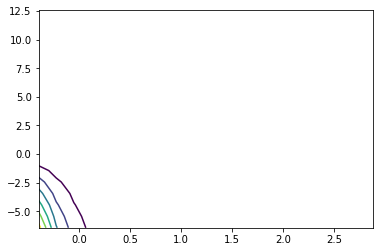

In [6]:
#TODO: To fix the likelihood contour plots

like_points = 80
sigma = 1.0
minuit=fit._iminuit_fit
x, y, z = minuit.contour('par_000_alpha', 'par_001_amplitude')
cs = plt.contour(x,y,z)
plt.clabel(cs);

## Plot the fitted Naima model (photon) spectrum and Logparabola fits to the data 

The details about the logparabola fit to all data is explained in the paper.
Together with the logparabola fit to the data, we show here the photon spectrum obtained 
using photon emission models.

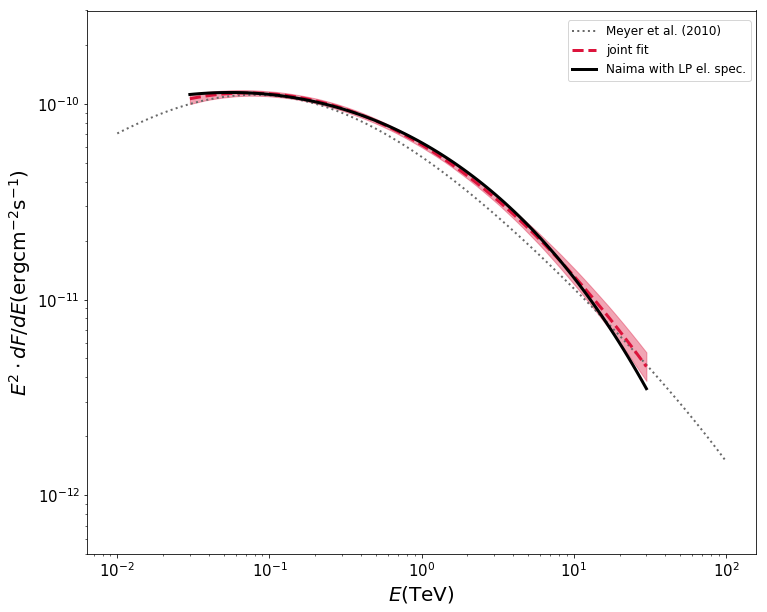

In [7]:
from gammapy.spectrum import CrabSpectrum
from joint_crab.utils import load_yaml
fig, ax = plt.subplots(figsize=(12,10))
    
# To plot a reference Crab nebula emission model spectrum from the literature
model_meyer_ref = CrabSpectrum('meyer').model
model_meyer_ref.plot([10 * u.GeV, 100 * u.TeV], energy_power=2, flux_unit='erg-1 cm-2 s-1',
                         ls=':', lw=2, color='dimgray', label='Meyer et al. (2010)')


path = config.repo_path / f'results/fit/gammapy/joint/fit_results_logparabola.yaml'
results = load_yaml(path)
parameters = results['parameters']
model_lp = models.LogParabola.from_log10(
           amplitude=parameters[0]['value'] * u.Unit(parameters[0]['unit']),
            reference=parameters[1]['value'] * u.Unit(parameters[1]['unit']),
            alpha=parameters[2]['value'] * u.Unit(parameters[2]['unit']),
            beta=parameters[3]['value'] * u.Unit(parameters[3]['unit'])
        )
 
# energy range for the plot
        
dataset = config.get_dataset('joint')
energy_range = dataset.energy_range

model_lp.plot(energy_range, energy_power=2, flux_unit='erg-1 cm-2 s-1',
                          ls='--', lw=3, color='crimson', label='joint fit')


# read the butterfly from the multivariate sampling results
table_path = Path(f'{config.repo_path}/results/figures/stat_err/joint_flux_errorband.dat')

# To read reading butterfly values from {table_path}
t = Table.read(table_path, format='ascii.ecsv')
energies = t['energies'].data * t['energies'].unit
flux_lo = t['flux_lo'].data * t['flux_lo'].unit
flux_hi = t['flux_hi'].data * t['flux_hi'].unit
        

plt.fill_between(
            energies.to('TeV'),
            (energies ** 2 * flux_lo).to('erg cm-2 s-1'),
            (energies ** 2 * flux_hi).to('erg cm-2 s-1'),
            color='crimson',
            alpha=0.38,
            label=''
        )

# In case a different energy range is asked
#energy_range = [0.02, 40] * u.TeV

# The best-fit photon spectrum
model_fit.plot(energy_power=2,energy_range=energy_range,lw=3,color='black',
                     flux_unit='erg-1 cm-2 s-1',label='Naima with LP el. spec.')

# This is to plot the orginal model (i.e. photon spectrum before the fit)
#model_naima.plot(energy_power=2,energy_range=energy_range,lw=3,color='black',
#                     flux_unit='erg-1 cm-2 s-1',label='Naima with LP el. spec.')

ax.set_ylim([5e-13, 3e-10])
ax.set_xlabel(r'$E (\mathrm{TeV})$',fontsize=20)
ax.set_ylabel(r'$ E^2 \cdot dF/dE (\mathrm{erg}  \mathrm{cm}^{-2} \mathrm{s}^{-1})$',fontsize=20)
ax.tick_params(labelsize=15)
fig.legend(bbox_to_anchor=(0.65, 0.83),loc=2,fontsize=12)
plt.show()